In [5]:
# To show the output of all lines in a cell rather that just the last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
import pandas as pd

Link to download the data: https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set#sentiment%20labelled%20sentences.zip

In [4]:
data_amazon = pd.read_table("~/Downloads/sentiment_labelled_sentences/amazon_cells_labelled.txt"
                          , sep='\t', header=None, names=['sentence', 'sentiment'])
data_imdb = pd.read_table("~/Downloads/sentiment_labelled_sentences/imdb_labelled.txt"
                          , sep='\t', header=None, names=['sentence', 'sentiment'])
data_yelp = pd.read_table("~/Downloads/sentiment_labelled_sentences/yelp_labelled.txt"
                          , sep='\t', header=None, names=['sentence', 'sentiment'])

Pandas Dataframes are similar to Spark Dataframes.

In [5]:
data_amazon.head(3)
data_imdb.head(3)
data_yelp.head(3)

,sentence,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1


,sentence,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0


,sentence,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0


In [6]:
data_amazon.shape
data_imdb.shape
data_yelp.shape

(1000, 2)

(748, 2)

(1000, 2)

In [7]:
all_data = pd.concat([data_amazon, data_imdb, data_yelp])

In [8]:
all_data.shape

(2748, 2)

,sentence,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1


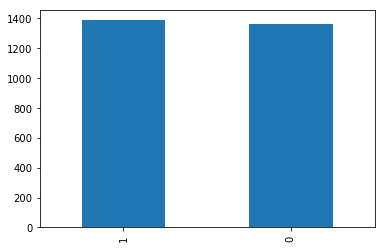

In [9]:
%matplotlib inline

all_data.head(3)
all_data['sentiment'].value_counts().plot(kind='bar')

So AUC-ROC metric is ok (there isn't class imbalance). We will also look at other metrics as well.

In [10]:
sample_data = [['Good case for the money!', 1], ['Do not waste your money.', 0], ['Good product. Love it!', 1]] 
small_sample = pd.DataFrame(sample_data, columns = ['sentence', 'sentiment']) 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [12]:
lr = LogisticRegression(penalty='l2', C=.8, random_state=21)

In [8]:
??CountVectorizer
# ??TfidfTransformer
# ??LogisticRegression

In [14]:
count_vec = CountVectorizer(binary=False, stop_words='english', ngram_range=(1,1))
# count_vec = CountVectorizer(binary=False, stop_words='english', ngram_range=(2,2))
# count_vec = CountVectorizer(binary=False, stop_words='None', ngram_range=(2,2))
count_vec.fit(small_sample.sentence)
small_transformed = count_vec.transform(small_sample.sentence)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
pd.set_option('display.max_colwidth', -1)
small_sample

,sentence,sentiment
0,Good case for the money!,1
1,Do not waste your money.,0
2,Good product. Love it!,1


In [16]:
from pandas import DataFrame

print(DataFrame(small_transformed.A, columns=count_vec.get_feature_names()).to_string())

   case  good  love  money  product  waste
0  1     1     0     1      0        0    
1  0     0     0     1      0        1    
2  0     1     1     0      1        0    


In [17]:
type(small_transformed)
small_transformed.A # .A return an ndarray from the sparse matrix

scipy.sparse.csr.csr_matrix

array([[1, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 1, 0]])

In [18]:
tfidf = TfidfTransformer(use_idf=True)
tfidf.fit(small_transformed)
small_tfidfed = tfidf.transform(small_transformed)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [19]:
print(DataFrame(small_tfidfed.A, columns=count_vec.get_feature_names()).to_string())

       case      good      love     money   product     waste
0  0.680919  0.517856  0.000000  0.517856  0.000000  0.000000
1  0.000000  0.000000  0.000000  0.605349  0.000000  0.795961
2  0.000000  0.473630  0.622766  0.000000  0.622766  0.000000


In [20]:
small_tfidfed.A

array([[ 0.68091856,  0.51785612,  0.        ,  0.51785612,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.60534851,  0.        ,
         0.79596054],
       [ 0.        ,  0.4736296 ,  0.62276601,  0.        ,  0.62276601,
         0.        ]])

In [21]:
text_classifier = Pipeline([
    ('vectorizer', CountVectorizer(binary=False, stop_words='english', ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', lr),
#     ('clf', SGDClassifier()), #by default, this is SVM
])

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     all_data.sentence, all_data.sentiment, test_size=0.35, random_state=4)

In [23]:
text_classifier.fit(X_train, y_train) 

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
  ...alty='l2', random_state=21, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [24]:
X_test[0:4]
y_test[0:4]

177    The atmosphere is modern and hip, while maintaining a touch of coziness.
720    Cute, quaint, simple, honest.                                           
525    It's an empty, hollow shell of a movie.                                 
630    Don't bother - go to the store.                                         
Name: sentence, dtype: object

177    1
720    1
525    0
630    0
Name: sentiment, dtype: int64

In [25]:
type(X_test)
type(y_test)

pandas.core.series.Series

pandas.core.series.Series

In [26]:
X_test = X_test.reset_index(drop = True) # drop=True discards the old index
X_test[0:4]

y_test = y_test.reset_index(drop = True)
y_test[0:4]

0    The atmosphere is modern and hip, while maintaining a touch of coziness.
1    Cute, quaint, simple, honest.                                           
2    It's an empty, hollow shell of a movie.                                 
3    Don't bother - go to the store.                                         
Name: sentence, dtype: object

0    1
1    1
2    0
3    0
Name: sentiment, dtype: int64

In [27]:
predicted_test = text_classifier.predict(X_test)
predicted_proba_test = text_classifier.predict_proba(X_test)

for i in range(5):
    print("{}, {}, {}, {}".format(X_test[i], predicted_test[i], predicted_proba_test[i], y_test[i]))

The atmosphere is modern and hip, while maintaining a touch of coziness., 1, [ 0.48580128  0.51419872], 1
Cute, quaint, simple, honest., 0, [ 0.55741558  0.44258442], 1
It's an empty, hollow shell of a movie.  , 1, [ 0.44886372  0.55113628], 0
Don't bother - go to the store., 0, [ 0.65667888  0.34332112], 0
To those who find this movie intelligent or even masterful, I can only say - it's your intelligence and your imagination you obviously used to try and make some sense of this pitiful attempt (it's in our human nature to try and make sense of things) .  , 0, [ 0.5411766  0.4588234], 0


In [28]:
from sklearn import metrics

predicted_train = text_classifier.predict(X_train)

y_train = y_train.astype('category')
print(metrics.classification_report(y_train, predicted_train,
    labels=y_train.cat.categories.tolist()))

metrics.confusion_matrix(y_train, predicted_train)

predicted_test = text_classifier.predict(X_test)

y_test = y_test.astype('category')
print(metrics.classification_report(y_test, predicted_test,
    labels=y_test.cat.categories.tolist()))

metrics.confusion_matrix(y_test, predicted_test)

             precision    recall  f1-score   support

          0       0.98      0.97      0.98       880
          1       0.97      0.98      0.98       906

avg / total       0.98      0.98      0.98      1786



array([[855,  25],
       [ 14, 892]])

             precision    recall  f1-score   support

          0       0.81      0.80      0.80       482
          1       0.80      0.81      0.80       480

avg / total       0.80      0.80      0.80       962



array([[386,  96],
       [ 93, 387]])

In [29]:
# ??metrics.classification_report(y_train, predicted_train, labels=y_train.cat.categories.tolist())
# ??metrics.precision_score
metrics.precision_score(y_test, predicted_test, average='macro') 
metrics.precision_score(y_test, predicted_test, average='micro') 
metrics.precision_score(y_test, predicted_test, average='weighted') 
metrics.recall_score(y_test, predicted_test, average='micro')

0.80354387375354963

0.80353430353430355

0.80354865886317273

0.80353430353430355

Be aware of the macro vs. micro vs. weighted averages. Look at the one based on your problem.  In multi-class classification sometimes some of these metrics are equal. E.g. ***micro-average precision and recall are always the same.***

Trained model predicting on a single sample

In [31]:
text_classifier.predict_proba(['Dogs love us!'])

array([[ 0.27486995,  0.72513005]])

## One week later!!!

In [32]:
# sw = , ng = (1, 2), mf = 2000, b = False, n = l2, ui = True, p = l1, c = 0.9
text_classifier2 = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=None, ngram_range=(1, 2), max_features=2000, binary=False)),
    ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
    ('clf', LogisticRegression(penalty='l1', C=0.9, random_state=21)),
])

In [45]:
text_classifier2.fit(all_data['sentence'], all_data['sentiment']) 

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...alty='l1', random_state=21, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Better to do train/test/eval and then use eval for text_classifier2's performance metrics..

#### The model is now portable:

In [37]:
import pickle

# save the model to disk
filename = 'model_v1.pkl'
pickle.dump(text_classifier2, open(filename, 'wb'), protocol=2)
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
print("%2.1f%% Positive" % (100 * loaded_model.predict_proba(["But he does like you!"])[0:1][:,1][0]))

46.0% Positive


In [38]:
"%2.1f%% Positive" % (100 * loaded_model.predict_proba(["But he does like you!"])[0:1][:,1][0])

'46.0% Positive'

##### During that one week

In [39]:
def grid_search(stop_words_list, ngram_ranges_list, max_features_list, binary_list, #CV
               norm_list, use_idf_list, #TFIDF
               penalty_list, C_list #LR 
               ):
    for sw in stop_words_list:
        for ng in ngram_ranges_list:
            for mf in max_features_list:
                for b in binary_list:
                    for n in norm_list:
                        for ui in use_idf_list:
                            for p in penalty_list:
                                for c in C_list:
                                    text_classifier = Pipeline([
                                        ('vectorizer', CountVectorizer(stop_words=sw, ngram_range=ng, max_features=mf, binary=b)),
                                        ('tfidf', TfidfTransformer(norm=n, use_idf=ui)),
                                        ('clf', LogisticRegression(penalty=p, C=c, random_state=21)),

                                    ])
                                    text_classifier.fit(X_train, y_train) 
                                    predicted_train = text_classifier.predict(X_train)
                                    predicted_test = text_classifier.predict(X_test)
                                    prec_train = round(metrics.recall_score(y_train, predicted_train, average='micro'), 2)
                                    prec_test = round(metrics.recall_score(y_test, predicted_test, average='micro'), 2)
                                    ratio = prec_train/prec_test
                                    if (ratio > 0.92) & (ratio < 1.07) & (prec_train > 0.7):
                                        print("prec_trn {}, prec_tst {} *** sw = {}, ng = {}, mf = {}, b = {}, n = {}, ui = {}, p = {}, c = {}".format(prec_train, prec_test, sw, ng, mf, b, n, ui, p, c))
                                    else:
                                        print("prec_trn {}, prec_tst {}     sw = {}, ng = {}, mf = {}, b = {}, n = {}, ui = {}, p = {}, c = {}".format(prec_train, prec_test, sw, ng, mf, b, n, ui, p, c))

In [40]:
grid_search(stop_words_list=['english', None], ngram_ranges_list=[(1,2), (1,3)], max_features_list=[2000, 5000, 60000], binary_list=[True, False],
            norm_list=['l2', 'l1'], use_idf_list=[True, False],
            penalty_list=['l1', 'l2'], C_list=[.01, 0.07, 0.1, 0.2, 0.9])

prec_trn 0.49, prec_tst 0.5     sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l1, c = 0.01
prec_trn 0.55, prec_tst 0.57     sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l1, c = 0.07
prec_trn 0.59, prec_tst 0.6     sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l1, c = 0.1
prec_trn 0.62, prec_tst 0.64     sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l1, c = 0.2
prec_trn 0.78, prec_tst 0.75 *** sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l1, c = 0.9
prec_trn 0.63, prec_tst 0.61     sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l2, c = 0.01
prec_trn 0.88, prec_tst 0.79     sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l2, c = 0.07
prec_trn 0.89, prec_tst 0.81     sw = english, ng = (1, 2), mf = 2000, b = True, n = l2, ui = True, p = l2, c = 0.1
prec_trn 0.89, prec_tst 0.81     sw = english, ng = (1, 2), mf = 2000,

One possible good model: `prec_trn 0.79, prec_tst 0.78 *** sw = None, ng = (1, 2), mf = 2000, b = False, n = l2, ui = True, p = l1, c = 0.9`